# Boilerplate code

In [1]:
# Boilerplate codes. 
import os
import sys
import spotipy
import spotipy.util as util
import json

Spotify = spotipy.Spotify

## spotify account details
## you can save those in your .bash_profile file and access it from there..

## this way
# os.environ['SPOTIPY_CLIENT_ID'] = 'your-spotify-client-id'
# os.environ['SPOTIPY_CLIENT_SECRET'] = 'your-spotify-client-secret'
# os.environ['SPOTIPY_REDIRECT_URI'] = 'your-app-redirect-url'

## or this way. 
token = os.environ['SPOTIPY_CLIENT_TOKEN']
base_url = 'https://api.spotify.com'
scope = 'playlist-read-private'

# spotify:playlist:
token = util.prompt_for_user_token( token,scope=scope)
spotify_object = Spotify(auth=token)



# Creating database functions

In [2]:
# Creating DataBase functions
import sqlite3
from sqlite3 import Error

## write some functions to create batabase table and insert values
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return conn
## Creating table function
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        pass

## function to insert values        
def insert_values(conn, sql_statement, values):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(sql_statement, values)
    except Error as e:
        pass

In [3]:
def getting_playlist_data_to_database(playlist_id, playlist_owner, db, sql_table_statement, sql_value_statement):
    
    ## Getting a bit cleaned up. 
    results = spotify_object.user_playlist(playlist_owner, playlist_id)
    results = results['tracks']['items']
    
    ## initializing some lists.
    track_name = []
    track_popularity = []
    duration_ms = []
    artist_name = []
    track_id = []
    album_name = []
    release_date = []
    
    ## just going through the spotify object and retriving data. 
    for result in results:
        track_name.append(result['track']['name'])
        duration_ms.append(result['track']['duration_ms'])
        track_popularity.append(result['track']['popularity'])
        artist_name.append(result['track']['artists'][0]['name'])
        track_id.append(result['track']['id'])
        album_name.append(result['track']['album']['name'])
        release_date.append(result['track']['album']['release_date'])
        
    ## creating a connection with database
    conn = create_connection(db)
    create_table(conn, sql_table_statement)
    
    ## looping through all the lists and inserting values. 
    for i, n, p, d, at, alb, dt in zip(track_id, 
                                   track_name, 
                                   track_popularity, 
                                   duration_ms, 
                                   artist_name, 
                                   album_name, 
                                   release_date):
        values = (i, n, p, d, at, alb, dt)
        insert_values(conn, sql_value_statement, values)
        conn.commit()



# Table#1(tracks)

In [4]:
results = spotify_object.search("Rap Caviar", limit = 1, type='playlist')

In [5]:
# used this to have print readable spotify_object
# print (json.dumps(artist, sort_keys=True, indent=4))

In [6]:
playlist_id =  results['playlists']['items'][0]['id']
playlist_owner = results['playlists']['items'][0]['owner']['id']

In [7]:
sqlite_db = '360i_db.sqlite'

## Getting playlist id and owner name of the playlist(spotify)
playlist_id =  results['playlists']['items'][0]['id']
playlist_owner = results['playlists']['items'][0]['owner']['id']

## sql_command for creating table. 
sql_table = 'CREATE TABLE IF NOT EXISTS tracks(track_id CHAR(20) PRIMARY KEY, name TEXT, popularity INTEGER, duration_ms INTEGER, artist_name TEXT, album TEXT, release_date TEXT);'

## sql command for inserting values
value_statement = 'INSERT INTO tracks VALUES (?,?,?,?,?,?,?)'

In [8]:
## this function creates database and inserts values. 
getting_playlist_data_to_database(playlist_id, playlist_owner, sqlite_db,sql_table, value_statement)

## Table#2 (Artists)

In [9]:
results = spotify_object.user_playlist(playlist_owner, playlist_id)
results = results['tracks']['items']

In [10]:
## Initializing a dict to store unique artist id and name. This is to avoid duplicates.  
artist_dict = {}
for result in results:
    for item in result['track']['artists']:
        if item['id'] in artist_dict:
            continue
        else:
            artist_dict[item['id']] = item['name']

## using the created dict above to get popularity and followers column. 
for key,value in artist_dict.items():
    try:
        artist_dict[key] = (value, spotify_object.artist(key)['popularity'], spotify_object.artist(key)['followers']['total'])
    except:
        artist_dict[key] = (value, 'NA', 'NA')


In [11]:
## getting rid of values that are NA. 
artist_dict = {i: v for i, v in artist_dict.items() if v[1] != 'NA'}

In [12]:
## Creating 'artists' table
conn = sqlite3.connect(sqlite_db)
sql_statement = 'CREATE TABLE IF NOT EXISTS artists(artist_id CHAR(22) PRIMARY KEY, name TEXT, popularity INTEGER, followers INTEGER);'
create_table(conn, sql_statement)

In [13]:
## Inserting values. 
for key, value in artist_dict.items():
    values = (key, value[0], value[1], value[2])
    insert_values(conn, 'INSERT INTO artists VALUES (?,?,?,?)', values)
    conn.commit()

## Analysis

In [14]:
import pandas as pd
from pandas.io import sql

## Writing a little function to make our life a bit easier. 
def Q(input_string, db = conn):
#     return sql.read_sql(input_string, db)
    return pd.read_sql(input_string, db)


## How many songs are there in the tracks table. 
Q('SELECT COUNT(*) FROM tracks')

,COUNT(*)
0,54


In [15]:
## What are the top 5 tracks by artist follower count?
Q("""SELECT tracks."name" 
FROM tracks 
JOIN artists
ON tracks."artist_name" = artists."name"
ORDER BY artists."followers" DESC
LIMIT 5
""")

,name
0,NorthStar - Remix
1,Follow God
2,Futsal Shuffle 2020
3,HIGHEST IN THE ROOM
4,Immortal


In [16]:
## What are the top 5 tracks by artist follower count?
Q("""SELECT tracks."name", artists."name", artists."followers" 
FROM tracks 
JOIN artists
ON tracks."artist_name" = artists."name"
ORDER BY artists."followers" DESC
LIMIT 5
""")

,name,name,followers
0,NorthStar - Remix,XXXTENTACION,16760146
1,Follow God,Kanye West,10840912
2,Futsal Shuffle 2020,Lil Uzi Vert,7382041
3,HIGHEST IN THE ROOM,Travis Scott,7329878
4,Immortal,21 Savage,7107211


In [17]:
## Which song is the longest?
Q("""SELECT name, MAX(duration_ms) FROM tracks
""")

,name,MAX(duration_ms)
0,Hot (Remix) [feat. Gunna and Travis Scott],279906


In [18]:
## What is the relationship between track and artist popularity?
## Let's do a little analysis, 
df = Q("""SELECT tracks."popularity" as 'tracks_popularity', 
tracks."duration_ms", 
tracks."artist_name", 
artists."popularity" as 'artist_popularity',
artists."followers"
FROM tracks
JOIN artists
ON tracks."artist_name"= artists."name"
""")

In [19]:
df.head()

,tracks_popularity,duration_ms,artist_name,artist_popularity,followers
0,84,198912,Lil Uzi Vert,90,7382041
1,92,159714,DaBaby,94,1492998
2,97,175720,Travis Scott,97,7329878
3,82,196652,Roddy Ricch,89,890667
4,82,215380,Juice WRLD,98,6796358


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize = (15,12))
sns.scatterplot(x = 'tracks_popularity', y = 'artist_popularity',size = 'followers', data = df);

As you can see there is a positive correlation between tracks and artists popularity. It seems as if popular artists tend to produce popular tracks. However, sometimes things  as you can see the top left data point

# Bonus Analysis

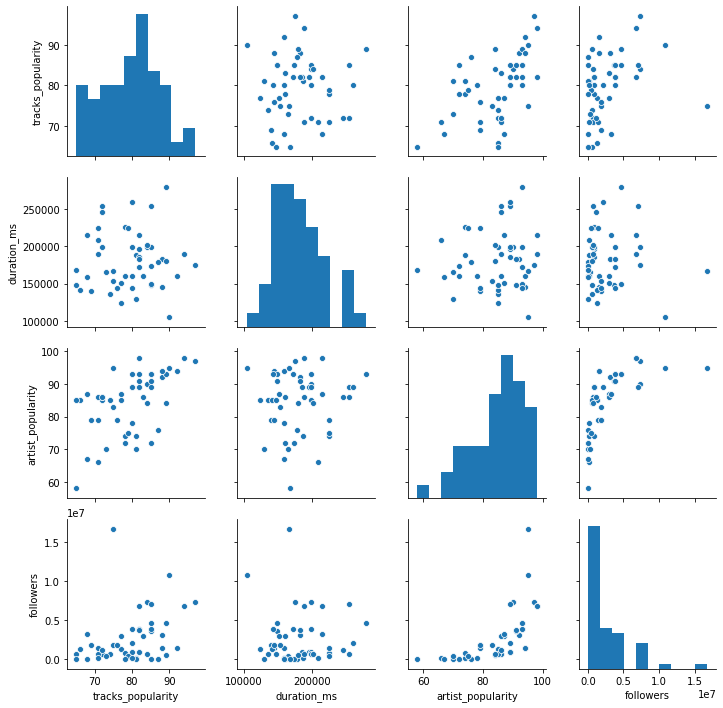

In [21]:
sns.pairplot(df);

It looks like there are a couple of datapoint in the followers column, that are outliers. If we get rid off those couple of points we might be able to get a better look at the data. Let's find out those artist with top followers. 

In [22]:
df.sort_values(by = 'followers', ascending = False).head(8)

,tracks_popularity,duration_ms,artist_name,artist_popularity,followers
44,75,166406,XXXTENTACION,95,16760146
40,90,104591,Kanye West,95,10840912
0,84,198912,Lil Uzi Vert,90,7382041
2,97,175720,Travis Scott,97,7329878
12,85,254723,21 Savage,89,7107211
4,82,215380,Juice WRLD,98,6796358
10,94,189322,Juice WRLD,98,6796358
6,89,279906,Young Thug,93,4638713


So, Drake and Post Malone are so far above and away from others that interms of followers that we may be better off leaving them out of the dataset. 

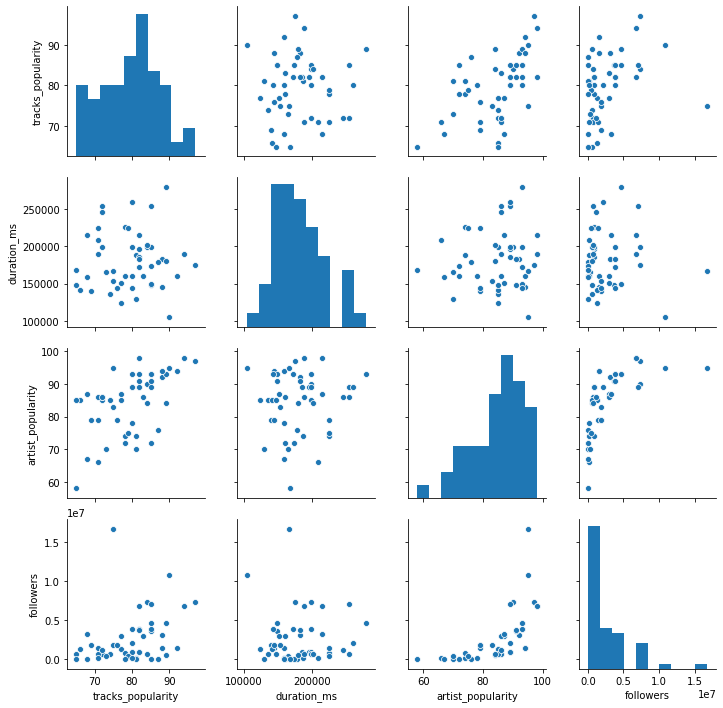

In [23]:
df_followers = df[df.followers <17356258]

sns.pairplot(df_followers);

Well, If we look at the top right plot,we see that there are a cluster of datapoints where tracks_popularity is fairly high eventhough there isn't enough followers. However, the relationship between artist_popularity and tracks_popularity is quite significant as we have discussed earlier. May be if we have more data we can reveal something more significant.

# Bonus Data

In [24]:
# results = spotify_object.search("biggest playlist ever.", limit = 10, type='playlist')
# results['playlists']['items']

In [25]:
sqlite_db = '360i_db.sqlite'
## Getting playlist id and owner name of the playlist(spotify)
playlist_owner = 'maxmoroz07'
playlist_id = '7htu5ftbLBRFAwiuHVcUAg'

## sql_command for creating table. 
sql_table = 'CREATE TABLE IF NOT EXISTS tracks_100(track_id CHAR(20) PRIMARY KEY, name TEXT, popularity INTEGER, duration_ms INTEGER, artist_name TEXT, album TEXT, release_date TEXT);'

## sql command for inserting values
value_statement = 'INSERT INTO tracks_100 VALUES (?,?,?,?,?,?,?)'

In [26]:
## this function creates database and inserts values. 
getting_playlist_data_to_database(playlist_id, playlist_owner, sqlite_db,sql_table, value_statement)

# Resources used
#### https://www.sqlitetutorial.net/sqlite-python/create-tables/ 
#### https://spotipy.readthedocs.io/en/latest/
 